<a href="https://colab.research.google.com/github/0AverageStudent0/SR_image/blob/main/s_final_year_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install matplotlib

In [ ]:
pip install opencv-python

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpg
import os
import zipfile
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, Dense, Flatten, Input,BatchNormalization,PReLU,LeakyReLU,Concatenate,ReLU,UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.nn import depth_to_space
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.math import reduce_mean,square
from tensorflow.keras.losses import MeanSquaredError,BinaryCrossentropy
from tensorflow.keras import Sequential
import re
import cv2

In [ ]:
def sift(image):
    image= cv2.imread(image)
    gray_scale= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, _= sift.detectAndCompute(image, None)
    sift_image = cv2.drawKeypoints(gray_scale, keypoints, None)
    plt.imshow(sift_image)
    plt.axis('off')
    return 'Number of Keypoints in this image are',len(keypoints)

In [ ]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
low_img = []
path = '/content/drive/MyDrive/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)

('Number of Keypoints in this image are', 142)

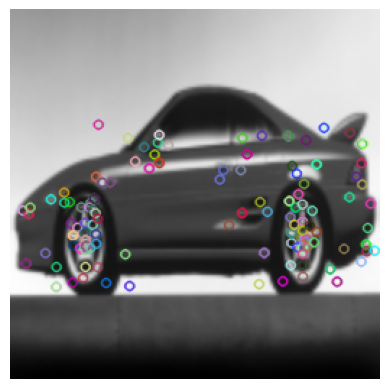

In [ ]:
sample_image=path+"/"+files[13]
sift(sample_image)

In [ ]:
def residual_blocks(input):
  x = Conv2D(64,(3,3),padding='same')(input)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Conv2D(64,(3,3),padding='same')(x)
  x = BatchNormalization()(x)
  x = Concatenate()([input,x])
  return x

def subpixel(input):
  x = UpSampling2D()(input)
  x = Conv2D(256,(3,3),padding='same')(x)
  x = ReLU()(x)
  return x

def generator():
  inputs = Input(shape=(64,64,3))
  x1 = Conv2D(64,(9,9),padding='same')(inputs)
  x1 = ReLU()(x1)
  r = residual_blocks(x1)
  for _ in range(15):
    r = residual_blocks(r)
  x2 = Conv2D(64,(3,3),padding='same')(r)
  x2 = BatchNormalization()(x2)
  merge = Concatenate()([x2,x1])

  x = subpixel(merge)
  x = subpixel(x)
  output = Conv2D(3,(9,9),padding='same',activation='sigmoid')(x)


  model = Model(inputs,output)
  return model

In [ ]:
g_model = generator()
g_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │     15,616 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ re_lu[0][0],      │
│ (Concatenate)       │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ concatenate[0][0… │
│ (Concatenate)       │ 192)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_5[0][0]  

 Total params: 7,203,651 (27.48 MB)

 Trainable params: 7,199,427 (27.46 MB)

 Non-trainable params: 4,224 (16.50 KB)

In [ ]:
def conv_block(input,n_channels):
  x = Conv2D(n_channels,(3,3),padding='same')(input)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.2)(x)
  x = Conv2D(n_channels,(3,3),padding='same',strides=(2,2))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.2)(x)
  return x


def discriminator():
  input = Input(shape=(256,256,3))
  c1 = Conv2D(64,(3,3),padding='same')(input)
  c1 = LeakyReLU(0.2)(c1)
  c1 = Conv2D(64,(3,3),padding='same',strides=(2,2))(c1)
  c1 = BatchNormalization()(c1)
  c1 = LeakyReLU(0.2)(c1)
  c2 = conv_block(c1,128)
  c3 = conv_block(c2,256)
  c4 = conv_block(c3,512)
  x = Flatten()(c4)
  x = Dense(1024)(x)
  x = LeakyReLU(0.2)(x)
  output = Dense(1,activation='sigmoid')(x)
  model = Model([input],output)
  return model

In [ ]:
d_model = discriminator()
d_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,80

 Total params: 138,912,577 (529.91 MB)

 Trainable params: 138,908,865 (529.90 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [ ]:
def vgg_model():
  selected_layers = ['block3_conv4' ]
  vgg_model = VGG19(include_top=False,
                    input_shape=(256,256,3))
  for layers in vgg_model.layers:
    layers.trainable = False
  model = Model(vgg_model.input,outputs=[vgg_model.get_layer(layer).output for layer in selected_layers])
  model.trainable = False
  return model

vgg_model = vgg_model()
vgg_model.summary()

vgg_model.trainable

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,325,568 (8.87 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,325,568 (8.87 MB)

False

In [ ]:
from tensorflow import add,dtypes
crossEntropy = BinaryCrossentropy()
mse = MeanSquaredError()
def discriminator_loss(real_output,fake_output,batch_size):
  valid = np.ones((batch_size,1))
  fake = np.zeros((batch_size,1))
  real_loss = crossEntropy(valid,real_output)
  fake_loss = crossEntropy(fake,fake_output)
  total_loss = 0.5*(real_loss + fake_loss)
  return total_loss

def generator_loss(generated_image,real_hr,batch_size):
  fake_image_features = vgg_model(generated_image)
  real_image_features = vgg_model(real_hr)
  vgg_loss = mse(fake_image_features,real_image_features)
  # Cast vgg_loss to tf.float32 to match the data type of gan_loss
  vgg_loss = dtypes.cast(vgg_loss,tf.float32)
  d_out_fake = d_model(generated_image)
  gan_loss = (1e-3)*crossEntropy(d_out_fake,np.ones((batch_size,1)))
  total_loss = add(gan_loss,vgg_loss)
  return total_loss

In [ ]:
lr_path ='/content/drive/MyDrive/dataset/Raw Data/low_res'
hr_path ='/content/drive/MyDrive/dataset/Raw Data/high_res'
lr = []
for image in sorted(os.listdir(lr_path)):
  img_path = os.path.join(lr_path,image)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(64,64))
  img = (img/255)
  img = img.astype('float32')
  lr.append(img)

hr =[]
for image in sorted(os.listdir(hr_path)):
  img_path = os.path.join(hr_path,image)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(256,256))
  img = (img/255)
  img = img.astype('float32')

  hr.append(img)

In [ ]:
lr[0].shape
type(lr[0])

numpy.ndarray

Text(0.5, 1.0, 'Low_resolution_image')

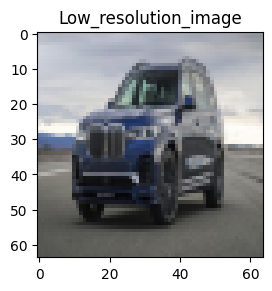

In [ ]:
plt.subplot(1,2,1)
plt.imshow(lr[10])
plt.title("Low_resolution_image")

In [ ]:
lr = np.reshape(lr,(len(lr),64,64,3))
hr = np.reshape(hr,(len(hr),256,256,3))
lr.shape,hr.shape

((855, 64, 64, 3), (855, 256, 256, 3))

In [ ]:
from tensorflow import GradientTape,function
generator_optimizer = Adam(learning_rate=0.0001,beta_1=0.9)
discriminator_optimizer = Adam(learning_rate=0.0001,beta_1=0.9)


@tf.function
def train_step(lr_images,hr_images,n_samples):
  with GradientTape() as disc_tape:
    generated_images = g_model(lr_images,training=True)
    real_output = d_model(hr_images,training=True)
    fake_output = d_model(generated_images,training=True)
    d_loss = discriminator_loss(real_output,fake_output,n_samples)
  gradients_of_discriminator = disc_tape.gradient(d_loss, d_model.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, d_model.trainable_variables))

  with tf.GradientTape() as gen_tape:
    fake_output = g_model(lr_images)
    g_loss = generator_loss(fake_output, hr_images,n_samples)

  gradients_of_generator = gen_tape.gradient(g_loss, g_model.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, g_model.trainable_variables))

  return d_loss,g_loss


In [ ]:
from keras.models import load_model

In [ ]:
def train(lr_images, hr_images, epochs=5, n_samples=5):
    num_images = len(lr_images)
    for epoch in range(epochs):
        for batch_start in range(0, num_images, n_samples):
            batch_end = min(batch_start + n_samples, num_images)
            input_lr = lr_images[batch_start:batch_end]
            input_hr = hr_images[batch_start:batch_end]
            d_loss, g_loss = train_step(input_lr, input_hr, n_samples)
            print(f'Epoch: {epoch + 1} - Batch: {batch_start // n_samples + 1}/{(num_images + n_samples - 1) // n_samples} - - {d_loss}, {g_loss}')
        if epoch % 10 == 0:
            file_name = f'generator_model_epoch_{epoch}.h5'
            g_model.save(file_name)

train(lr[:855], hr[:855])


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_109']
Received: inputs=Tensor(shape=(5, 256, 256, 3))
  warnings.warn(msg)


KeyboardInterrupt: 

In [ ]:
# Here we load the weights from the saved file
g_model.load_weights("generator_model_epoch_0.h5")
g_model.load_weights("generator_model_epoch_10.h5")
g_model.load_weights("generator_model_epoch_20.h5")
g_model.load_weights("generator_model_epoch_30.h5")
g_model.load_weights("generator_model_epoch_40.h5")

g_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

The shape of the image is (256, 256, 3)


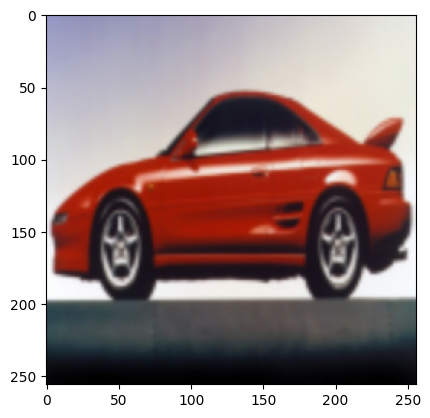

In [ ]:
img_path = '/content/drive/MyDrive/dataset/Raw Data/low_res/13.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img/255.
img = img.astype('float32')
print('The shape of the image is',img.shape)
plt.imshow(img)

The shape of the image is (64, 64, 3)


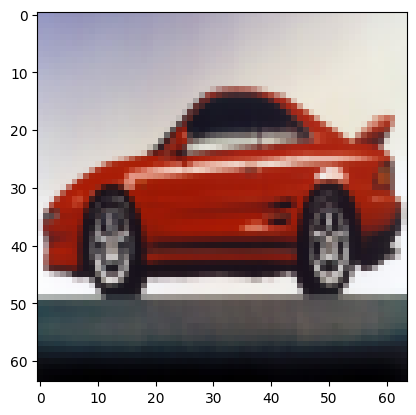

In [ ]:
img_path = '/content/drive/MyDrive/dataset/Raw Data/low_res/13.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (64, 64)) # Resize the image to (64, 64)
img = img/255.
img = img.astype('float32')
print('The shape of the image is',img.shape)
plt.imshow(img)

In [ ]:
in_img = np.expand_dims(img,axis=0)
a = g_model.predict(in_img)
a = np.squeeze(a,axis=0)
plt.imshow(a)
plt.axis('off')
plt.savefig('/content/drive/MyDrive/dataset/generated_HR_13', bbox_inches='tight', pad_inches=0)  # Save the image
plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


In [ ]:
def sift(image):
    image= cv2.imread(image)
    gray_scale= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Create a SIFT object within the function
    sift_create = cv2.SIFT_create()
    keypoints, _= sift_create.detectAndCompute(image, None)  # Call detectAndCompute on the SIFT object
    sift_image = cv2.drawKeypoints(gray_scale, keypoints, None)
    plt.imshow(sift_image)
    plt.axis('off')
    return 'Number of Keypoints in this image are',len(keypoints)

('Number of Keypoints in this image are', 326)

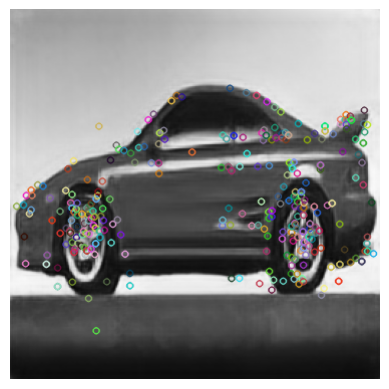

In [ ]:
path_13 = "/content/drive/MyDrive/dataset/generated_HR_13.png"
sift(path_13)

In [ ]:
def calculate_psnr(original_img, processed_img, max_pixel_value):
    mse = np.mean((original_img - processed_img) ** 2)
    psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    return psnr

original_image = cv2.imread('/content/drive/MyDrive/dataset/Raw Data/high_res/13.png', cv2.IMREAD_GRAYSCALE)
processed_image = cv2.imread("/content/drive/MyDrive/dataset/generated_HR_13.png", cv2.IMREAD_GRAYSCALE)
original_image = cv2.resize(original_image, (processed_image.shape[1], processed_image.shape[0]))
original_image = original_image.astype(np.float64)
processed_image = processed_image.astype(np.float64)
max_pixel_value = 255
psnr = calculate_psnr(original_image, processed_image, max_pixel_value)

print("The PSNR value between the original image and processed image is:", psnr, "dB")

The PSNR value between the original image and processed image is: 25.482262927280125 dB


In [ ]:
import numpy as np
import cv2

def calculate_ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2
    mu1 = np.mean(img1)
    mu2 = np.mean(img2)
    sigma1_sq = np.var(img1)
    sigma2_sq = np.var(img2)
    sigma12 = np.cov(img1.flatten(), img2.flatten())[0, 1]
    ssim_value = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / ((mu1**2 + mu2**2 + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_value

In [ ]:
import cv2
import numpy as np

img_lr = cv2.imread('/content/drive/MyDrive/dataset/Raw Data/low_res/13.png', cv2.IMREAD_GRAYSCALE)

img_hr = cv2.imread('/content/drive/MyDrive/dataset/generated_HR_13.png', cv2.IMREAD_GRAYSCALE)
sift = cv2.SIFT_create()
keypoints_lr, descriptors_lr = sift.detectAndCompute(img_lr, None)
keypoints_hr, descriptors_hr = sift.detectAndCompute(img_hr, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_lr, descriptors_hr, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

num_matched_keypoints = len(good_matches)
print("Number of keypoints matched:", num_matched_keypoints)

Number of keypoints matched: 68


The shape of the image is (256, 256, 3)


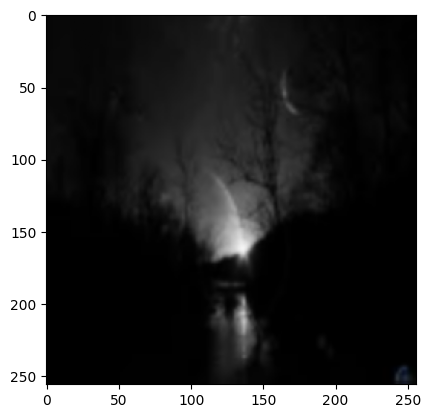

In [ ]:
img_path_14 = '/content/drive/MyDrive/dataset/Raw Data/low_res/14.png'
img_14 = cv2.imread(img_path_14)
img_14 = cv2.cvtColor(img_14, cv2.COLOR_BGR2RGB)
img_14 = img_14/255.
img_14 = img_14.astype('float32')
print('The shape of the image is',img_14.shape)
plt.imshow(img_14)

In [ ]:
def sift(image):
    image= cv2.imread(image)
    gray_scale= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, _= sift.detectAndCompute(image, None)
    sift_image = cv2.drawKeypoints(gray_scale, keypoints, None)
    plt.imshow(sift_image)
    plt.axis('off')
    return 'Number of Keypoints in this image are',len(keypoints)

('Number of Keypoints in this image are', 36)

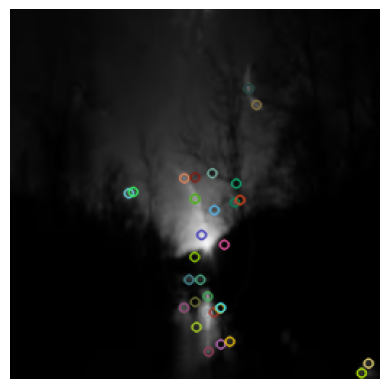

In [ ]:
sift(img_path_14)

In [ ]:
in_img_14 = np.expand_dims(img_14,axis=0)
b = g_model.predict(in_img_14)
b = np.squeeze(b,axis=0)
plt.imshow(b)
plt.axis('off')
plt.savefig('/content/drive/MyDrive/dataset/generated_HR_14', bbox_inches='tight', pad_inches=0)  # Save the image
plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 65s 65s/step


('Number of Keypoints in this image are', 38)

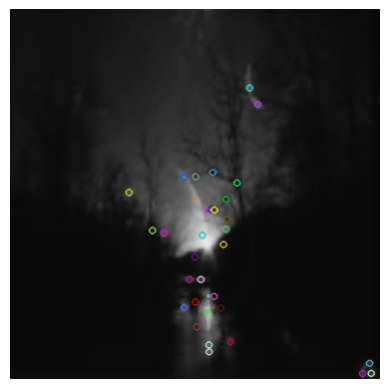

In [ ]:
path_14 = "/content/drive/MyDrive/dataset/generated_HR_14.png"
sift(path_14)

In [ ]:
def calculate_psnr(original_img, processed_img, max_pixel_value):
    mse = np.mean((original_img - processed_img) ** 2)
    psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    return psnr

original_image = cv2.imread('/content/drive/MyDrive/dataset/Raw Data/high_res/14.png', cv2.IMREAD_GRAYSCALE)
processed_image = cv2.imread("/content/drive/MyDrive/dataset/generated_HR_14.png", cv2.IMREAD_GRAYSCALE)
original_image = cv2.resize(original_image, (processed_image.shape[1], processed_image.shape[0]))
original_image = original_image.astype(np.float64)
processed_image = processed_image.astype(np.float64)
max_pixel_value = 255
psnr = calculate_psnr(original_image, processed_image, max_pixel_value)

print("The PSNR value between the original image and processed image is:", psnr, "dB")

The PSNR value between the original image and processed image is: 29.008447850028418 dB


In [ ]:
generated_hr_image = cv2.imread('/content/drive/MyDrive/dataset/generated_HR_14.png', cv2.IMREAD_GRAYSCALE)
ground_truth_hr_image = cv2.imread('/content/drive/MyDrive/dataset/Raw Data/high_res/14.png', cv2.IMREAD_GRAYSCALE)
ground_truth_hr_image_resized = cv2.resize(ground_truth_hr_image, (generated_hr_image.shape[1], generated_hr_image.shape[0]))
ssim_value = calculate_ssim(generated_hr_image, ground_truth_hr_image_resized)
print("SSIM between generated HR image and ground truth HR image:", ssim_value)

SSIM between generated HR image and ground truth HR image: 0.9117044502552117


In [ ]:
import cv2
import numpy as np

img_lr = cv2.imread('/content/drive/MyDrive/dataset/Raw Data/low_res/14.png', cv2.IMREAD_GRAYSCALE)

img_hr = cv2.imread('/content/drive/MyDrive/dataset/generated_HR_14.png', cv2.IMREAD_GRAYSCALE)
sift = cv2.SIFT_create()
keypoints_lr, descriptors_lr = sift.detectAndCompute(img_lr, None)
keypoints_hr, descriptors_hr = sift.detectAndCompute(img_hr, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_lr, descriptors_hr, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

num_matched_keypoints = len(good_matches)
print("Number of keypoints matched:", num_matched_keypoints)

Number of keypoints matched: 25


The shape of the image is (256, 256, 3)


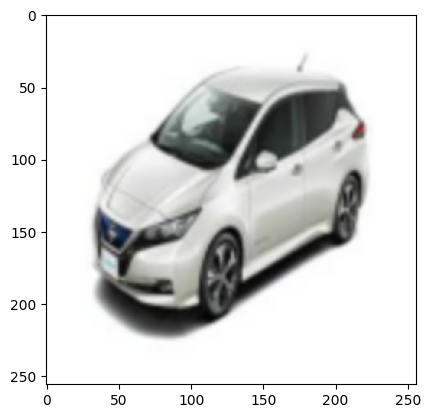

In [ ]:
img_path_16 = '/content/drive/MyDrive/dataset/Raw Data/low_res/16.png'
img_16 = cv2.imread(img_path_16)
img_16 = cv2.cvtColor(img_16, cv2.COLOR_BGR2RGB)
img_16 = img_16/255.
img_16 = img_16.astype('float32')
print('The shape of the image is',img_16.shape)
plt.imshow(img_16)

In [ ]:
def sift(image):
    image= cv2.imread(image)
    gray_scale= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Create a SIFT object within the function
    sift_create = cv2.SIFT_create()
    keypoints, _= sift_create.detectAndCompute(image, None)  # Call detectAndCompute on the SIFT object
    sift_image = cv2.drawKeypoints(gray_scale, keypoints, None)
    plt.imshow(sift_image)
    plt.axis('off')
    return 'Number of Keypoints in this image are',len(keypoints)

('Number of Keypoints in this image are', 175)

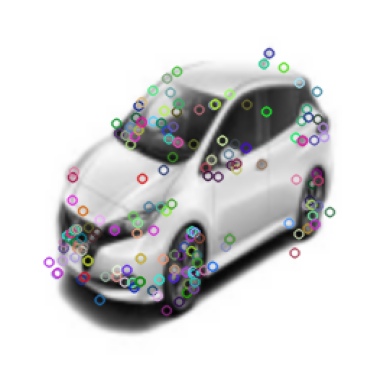

In [ ]:
sift(img_path_16)

In [ ]:
in_img_16 = np.expand_dims(img_16,axis=0)
c = g_model.predict(in_img_16)
c = np.squeeze(c,axis=0)
plt.imshow(c)
plt.axis('off')
plt.savefig('/content/drive/MyDrive/dataset/generated_HR_16', bbox_inches='tight', pad_inches=0)  # Save the image
plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


('Number of Keypoints in this image are', 207)

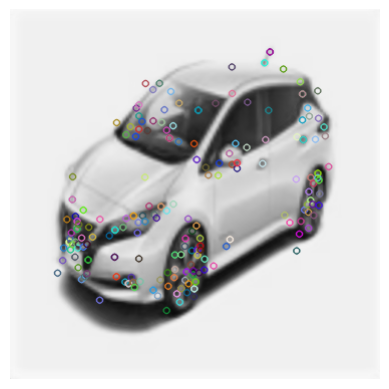

In [ ]:
path_16 = "/content/drive/MyDrive/dataset/generated_HR_16.png"
sift(path_16)

In [ ]:
def calculate_psnr(original_img, processed_img, max_pixel_value):
    mse = np.mean((original_img - processed_img) ** 2)
    psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    return psnr

original_image = cv2.imread('/content/drive/MyDrive/dataset/Raw Data/high_res/16.png', cv2.IMREAD_GRAYSCALE)
processed_image = cv2.imread("/content/drive/MyDrive/dataset/generated_HR_16.png", cv2.IMREAD_GRAYSCALE)
original_image = cv2.resize(original_image, (processed_image.shape[1], processed_image.shape[0]))
original_image = original_image.astype(np.float64)
processed_image = processed_image.astype(np.float64)
max_pixel_value = 255
psnr = calculate_psnr(original_image, processed_image, max_pixel_value)

print("The PSNR value between the original image and processed image is:", psnr, "dB")

The PSNR value between the original image and processed image is: 24.4209372475463 dB


In [ ]:
generated_hr_image = cv2.imread('/content/drive/MyDrive/dataset/generated_HR_16.png', cv2.IMREAD_GRAYSCALE)
ground_truth_hr_image = cv2.imread('/content/drive/MyDrive/dataset/Raw Data/high_res/16.png', cv2.IMREAD_GRAYSCALE)
ground_truth_hr_image_resized = cv2.resize(ground_truth_hr_image, (generated_hr_image.shape[1], generated_hr_image.shape[0]))
ssim_value = calculate_ssim(generated_hr_image, ground_truth_hr_image_resized)
print("SSIM between generated HR image and ground truth HR image:", ssim_value)

SSIM between generated HR image and ground truth HR image: 0.9848313782946678


In [ ]:
import cv2
import numpy as np

img_lr = cv2.imread('/content/drive/MyDrive/dataset/Raw Data/low_res/16.png', cv2.IMREAD_GRAYSCALE)
img_hr = cv2.imread('/content/drive/MyDrive/dataset/generated_HR_16.png', cv2.IMREAD_GRAYSCALE)
sift = cv2.SIFT_create()
keypoints_lr, descriptors_lr = sift.detectAndCompute(img_lr, None)
keypoints_hr, descriptors_hr = sift.detectAndCompute(img_hr, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_lr, descriptors_hr, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

num_matched_keypoints = len(good_matches)
print("Number of keypoints matched:", num_matched_keypoints)

Number of keypoints matched: 134


The shape of the image is (256, 256, 3)


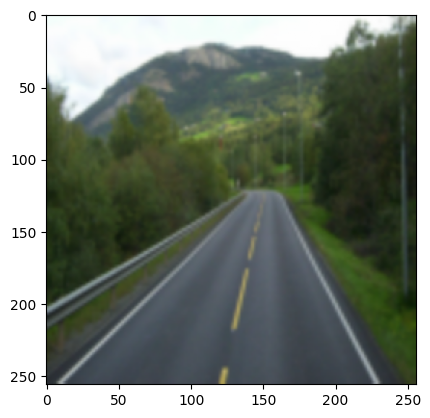

In [ ]:
img_path_171 = '/content/drive/MyDrive/dataset/Raw Data/low_res/171.png'
img_171 = cv2.imread(img_path_171)
img_171 = cv2.cvtColor(img_171, cv2.COLOR_BGR2RGB)
img_171 = img_171/255.
img_171 = img_171.astype('float32')
print('The shape of the image is',img_171.shape)
plt.imshow(img_171)

In [ ]:
def sift(image):
    image= cv2.imread(image)
    gray_scale= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Create a SIFT object within the function
    sift_create = cv2.SIFT_create()
    keypoints, _= sift_create.detectAndCompute(image, None)  # Call detectAndCompute on the SIFT object
    sift_image = cv2.drawKeypoints(gray_scale, keypoints, None)
    plt.imshow(sift_image)
    plt.axis('off')
    return 'Number of Keypoints in this image are',len(keypoints)

('Number of Keypoints in this image are', 97)

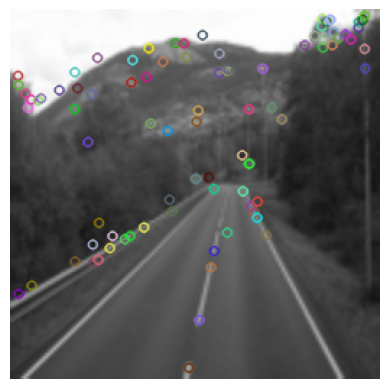

In [ ]:
sift(img_path_171)

In [ ]:
in_img_171 = np.expand_dims(img_171,axis=0)
c = g_model.predict(in_img_171)
c = np.squeeze(c,axis=0)
plt.imshow(c)
plt.axis('off')
plt.savefig('/content/drive/MyDrive/dataset/generated_HR_171', bbox_inches='tight', pad_inches=0)  # Save the image
plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


('Number of Keypoints in this image are', 116)

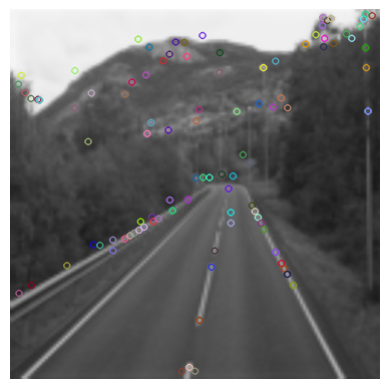

In [ ]:
path_171 = "/content/drive/MyDrive/dataset/generated_HR_171.png"
sift(path_171)

In [ ]:
def calculate_psnr(original_img, processed_img, max_pixel_value):
    mse = np.mean((original_img - processed_img) ** 2)
    psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    return psnr

original_image = cv2.imread('/content/drive/MyDrive/dataset/Raw Data/high_res/171.png', cv2.IMREAD_GRAYSCALE)
processed_image = cv2.imread("/content/drive/MyDrive/dataset/generated_HR_171.png", cv2.IMREAD_GRAYSCALE)
original_image = cv2.resize(original_image, (processed_image.shape[1], processed_image.shape[0]))
original_image = original_image.astype(np.float64)
processed_image = processed_image.astype(np.float64)
max_pixel_value = 255
psnr = calculate_psnr(original_image, processed_image, max_pixel_value)

print("The PSNR value between the original image and processed image is:", psnr, "dB")

The PSNR value between the original image and processed image is: 28.16485716482289 dB


In [ ]:
generated_hr_image = cv2.imread('/content/drive/MyDrive/dataset/generated_HR_171.png', cv2.IMREAD_GRAYSCALE)
ground_truth_hr_image = cv2.imread('/content/drive/MyDrive/dataset/Raw Data/high_res/171.png', cv2.IMREAD_GRAYSCALE)
ground_truth_hr_image_resized = cv2.resize(ground_truth_hr_image, (generated_hr_image.shape[1], generated_hr_image.shape[0]))
ssim_value = calculate_ssim(generated_hr_image, ground_truth_hr_image_resized)
print("SSIM between generated HR image and ground truth HR image:", ssim_value)


SSIM between generated HR image and ground truth HR image: 0.9857410286789516


In [ ]:
import cv2
import numpy as np

img_lr = cv2.imread('/content/drive/MyDrive/dataset/Raw Data/low_res/171.png', cv2.IMREAD_GRAYSCALE)

img_hr = cv2.imread('/content/drive/MyDrive/dataset/generated_HR_171.png', cv2.IMREAD_GRAYSCALE)
sift = cv2.SIFT_create()
keypoints_lr, descriptors_lr = sift.detectAndCompute(img_lr, None)
keypoints_hr, descriptors_hr = sift.detectAndCompute(img_hr, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_lr, descriptors_hr, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

num_matched_keypoints = len(good_matches)
print("Number of keypoints matched:", num_matched_keypoints)

Number of keypoints matched: 64


The shape of the image is (256, 256, 3)


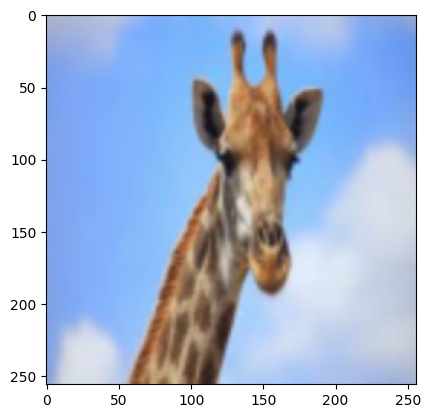

In [ ]:
img_path_543 = '/content/drive/MyDrive/dataset/Raw Data/low_res/543.png'
img_543 = cv2.imread(img_path_543)
img_543 = cv2.cvtColor(img_543, cv2.COLOR_BGR2RGB)
img_543 = img_543/255.
img_543 = img_543.astype('float32')
print('The shape of the image is',img_543.shape)
plt.imshow(img_543)

In [ ]:
def sift(image):
    image= cv2.imread(image)
    gray_scale= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Create a SIFT object within the function
    sift_create = cv2.SIFT_create()
    keypoints, _= sift_create.detectAndCompute(image, None)  # Call detectAndCompute on the SIFT object
    sift_image = cv2.drawKeypoints(gray_scale, keypoints, None)
    plt.imshow(sift_image)
    plt.axis('off')
    return 'Number of Keypoints in this image are',len(keypoints)

('Number of Keypoints in this image are', 145)

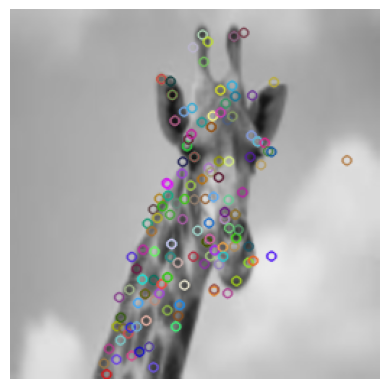

In [ ]:
sift(img_path_543)

In [ ]:
in_img_543 = np.expand_dims(img_543,axis=0)
d = g_model.predict(in_img_543)
d = np.squeeze(d,axis=0)
plt.imshow(d)
plt.axis('off')
plt.savefig('/content/drive/MyDrive/dataset/generated_HR_543', bbox_inches='tight', pad_inches=0)  # Save the image
plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


('Number of Keypoints in this image are', 152)

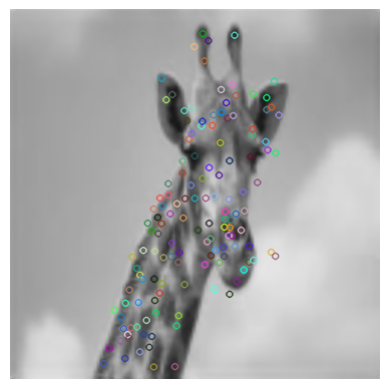

In [ ]:
path_543 = "/content/drive/MyDrive/dataset/generated_HR_543.png"
sift(path_543)

In [ ]:
def calculate_psnr(original_img, processed_img, max_pixel_value):
    mse = np.mean((original_img - processed_img) ** 2)
    psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    return psnr

original_image = cv2.imread('/content/drive/MyDrive/dataset/Raw Data/high_res/543.png', cv2.IMREAD_GRAYSCALE)
processed_image = cv2.imread("/content/drive/MyDrive/dataset/generated_HR_543.png", cv2.IMREAD_GRAYSCALE)
original_image = cv2.resize(original_image, (processed_image.shape[1], processed_image.shape[0]))
original_image = original_image.astype(np.float64)
processed_image = processed_image.astype(np.float64)
max_pixel_value = 255
psnr = calculate_psnr(original_image, processed_image, max_pixel_value)

print("The PSNR value between the original image and processed image is:", psnr, "dB")

The PSNR value between the original image and processed image is: 30.80056528394738 dB


In [ ]:
generated_hr_image = cv2.imread('/content/drive/MyDrive/dataset/generated_HR_543.png', cv2.IMREAD_GRAYSCALE)
ground_truth_hr_image = cv2.imread('/content/drive/MyDrive/dataset/Raw Data/high_res/543.png', cv2.IMREAD_GRAYSCALE)
ground_truth_hr_image_resized = cv2.resize(ground_truth_hr_image, (generated_hr_image.shape[1], generated_hr_image.shape[0]))
ssim_value = calculate_ssim(generated_hr_image, ground_truth_hr_image_resized)
print("SSIM between generated HR image and ground truth HR image:", ssim_value)


SSIM between generated HR image and ground truth HR image: 0.9880158818295001


In [ ]:
import cv2
import numpy as np

img_lr = cv2.imread('/content/drive/MyDrive/dataset/Raw Data/low_res/543.png', cv2.IMREAD_GRAYSCALE)

img_hr = cv2.imread('/content/drive/MyDrive/dataset/generated_HR_543.png', cv2.IMREAD_GRAYSCALE)
sift = cv2.SIFT_create()
keypoints_lr, descriptors_lr = sift.detectAndCompute(img_lr, None)
keypoints_hr, descriptors_hr = sift.detectAndCompute(img_hr, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_lr, descriptors_hr, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

num_matched_keypoints = len(good_matches)
print("Number of keypoints matched:", num_matched_keypoints)

Number of keypoints matched: 116


The shape of the image is (256, 256, 3)


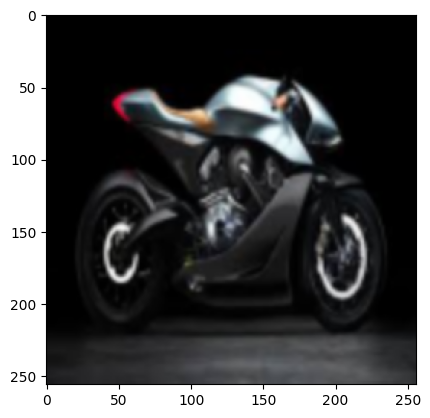

In [ ]:
img_path_10 = '/content/drive/MyDrive/dataset/Raw Data/low_res/10.png'
img_10 = cv2.imread(img_path_10)
img_10 = cv2.cvtColor(img_10, cv2.COLOR_BGR2RGB)
img_10 = img_10/255.
img_10 = img_10.astype('float32')
print('The shape of the image is',img_10.shape)
plt.imshow(img_10)

In [ ]:
def sift(image):
    image= cv2.imread(image)
    gray_scale= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Create a SIFT object within the function
    sift_create = cv2.SIFT_create()
    keypoints, _= sift_create.detectAndCompute(image, None)  # Call detectAndCompute on the SIFT object
    sift_image = cv2.drawKeypoints(gray_scale, keypoints, None)
    plt.imshow(sift_image)
    plt.axis('off')
    return 'Number of Keypoints in this image are',len(keypoints)

('Number of Keypoints in this image are', 198)

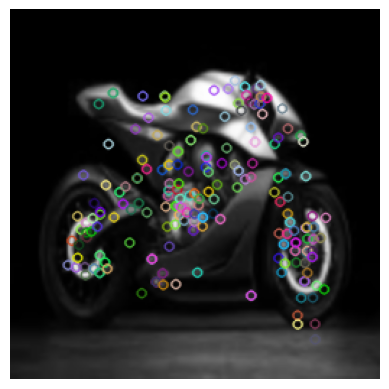

In [ ]:
sift(img_path_10)

In [ ]:
in_img_10 = np.expand_dims(img_10,axis=0)
d = g_model.predict(in_img_10)
d = np.squeeze(d,axis=0)
plt.imshow(d)
plt.axis('off')
plt.savefig('/content/drive/MyDrive/dataset/generated_HR_10', bbox_inches='tight', pad_inches=0)  # Save the image
plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


('Number of Keypoints in this image are', 221)

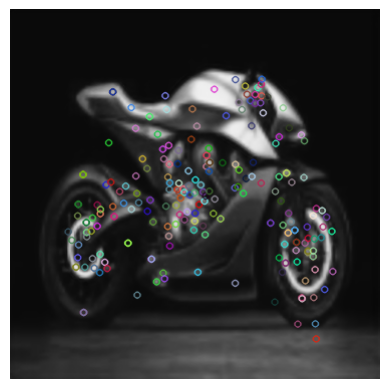

In [ ]:
path_543 = "/content/drive/MyDrive/dataset/generated_HR_10.png"
sift(path_543)

In [ ]:
def calculate_psnr(original_img, processed_img, max_pixel_value):
    mse = np.mean((original_img - processed_img) ** 2)
    psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    return psnr

original_image = cv2.imread('/content/drive/MyDrive/dataset/Raw Data/high_res/10.png', cv2.IMREAD_GRAYSCALE)
processed_image = cv2.imread("/content/drive/MyDrive/dataset/generated_HR_10.png", cv2.IMREAD_GRAYSCALE)
original_image = cv2.resize(original_image, (processed_image.shape[1], processed_image.shape[0]))
original_image = original_image.astype(np.float64)
processed_image = processed_image.astype(np.float64)
max_pixel_value = 255
psnr = calculate_psnr(original_image, processed_image, max_pixel_value)

print("The PSNR value between the original image and processed image is:", psnr, "dB")

The PSNR value between the original image and processed image is: 25.841296645367187 dB


In [ ]:
generated_hr_image = cv2.imread('/content/drive/MyDrive/dataset/generated_HR_10.png', cv2.IMREAD_GRAYSCALE)
ground_truth_hr_image = cv2.imread('/content/drive/MyDrive/dataset/Raw Data/high_res/10.png', cv2.IMREAD_GRAYSCALE)
ground_truth_hr_image_resized = cv2.resize(ground_truth_hr_image, (generated_hr_image.shape[1], generated_hr_image.shape[0]))
ssim_value = calculate_ssim(generated_hr_image, ground_truth_hr_image_resized)
print("SSIM between generated HR image and ground truth HR image:", ssim_value)


SSIM between generated HR image and ground truth HR image: 0.9500734055935407


In [ ]:
import cv2
import numpy as np

img_lr = cv2.imread('/content/drive/MyDrive/dataset/Raw Data/low_res/10.png', cv2.IMREAD_GRAYSCALE)

img_hr = cv2.imread('/content/drive/MyDrive/dataset/generated_HR_10.png', cv2.IMREAD_GRAYSCALE)
sift = cv2.SIFT_create()
keypoints_lr, descriptors_lr = sift.detectAndCompute(img_lr, None)
keypoints_hr, descriptors_hr = sift.detectAndCompute(img_hr, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_lr, descriptors_hr, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

num_matched_keypoints = len(good_matches)
print("Number of keypoints matched:", num_matched_keypoints)

Number of keypoints matched: 155
